In [1]:
%reset

In [2]:
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
import sys
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from getdist import plots, MCSamples
from scipy.integrate import simpson
from scipy.stats import norm

%matplotlib inline

In [3]:
source_type = 'spiral_galaxy'

In [4]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [2000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
# luminosity_range = 10.0**np.array([30, 37])
max_radius = 8.5 + 20*2 #kpc
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut = np.pi #10*u.deg.to('rad') #degrees
angular_cut_gen = np.pi
lat_cut = 0 #2*u.deg.to('rad') #degrees
lat_cut_gen = 0

In [5]:
my_cosmology = 'Planck18'
z_range = [0, 14]
energy_range_gen = [energy_range_gen[0], energy_range[1]*1.5*z_range[1]]
luminosity_range = 10.0**np.array([37, 50]) # Minimum value set by considering Andromeda distance using Fermi as benchmark and receiving 0.1 photon at detector side
# luminosity_range = 10.0**np.array([50, 70])
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen, angular_cut_gen, lat_cut_gen, cosmology = my_cosmology, z_range = z_range, verbose = False)

In [6]:
# L_IR_min/max values are chosen by plotting the integrand with respect to log_LIR and ensuring the integrand is sufficently supressed at the min/max values of LIR.
LIR_min = 1e-5  # solar luminosity
LIR_max = 1e25  # solar luminosity

#log_LIR = log_10(L_IR / solar_luminosity) # unitless
log_LIR_min = np.log10(LIR_min)
log_LIR_max = np.log10(LIR_max)

res=int(1e4)
log_LIRs = np.linspace(log_LIR_min, log_LIR_max, res)

In [ ]:
def Phi_IR(log_LIR, Lstar): #log_LIR = log_10(L_IR / solar_luminosity) # unitless

        # from Table 8 in Gruppioni et al.
        if source_type == 'spiral_galaxy':
                Phi_star = 10**(-2.08) # Mpc^{-3} dex^{-1}
                # L_star = 10**(9.46) # Solar luminosity
                alpha = 1.00
                sigma = 0.50
        elif source_type == 'starburst_galaxy':
                Phi_star = 10**(-4.74) # Mpc^{-3} dex^{-1}
                # L_star = 10**(11.02) # Solar luminosity
                alpha = 1.00
                sigma = 0.35
        elif source_type == 'SF_AGN':
                Phi_star = 10**(-3.25) # Mpc^{-3} dex^{-1}
                # L_star = 10**(10.57) # Solar luminosity
                alpha = 1.20
                sigma = 0.40

        LIR = 10**log_LIR # solar luminosity

        Phi_IR = Phi_star * (LIR / Lstar)**(1 - alpha) * np.exp(-1 / (2 * sigma**2) * (np.log10(1 + LIR / Lstar))**2) # from Gruppioni paper eqn (3)  	

        return Phi_IR

In [8]:
def PDF_log_Lgamma_given_log_LIR(log_LIR, log_Lgamma): #log_LIR = log_10(L_IR / solar_luminosity) # unitless
    LIR_solar_luminosity = 10**log_LIR # Solar luminosity
    L_IR_erg_second = LIR_solar_luminosity * 3.826e33 # erg/s

    a = 1.09
    g = 40.8
    sigma_SF = 0.202 

    mean = g + a * np.log10(L_IR_erg_second / 1e45)
    std = sigma_SF

    # print(f"norm.pdf() = {norm.pdf(log_Lgamma, loc=mean, scale=std)}")

    return norm.pdf(log_Lgamma, loc=mean, scale=std)

In [9]:
def integrand(PhiIR_of_logLIRs, log_LIRs, log_Lgamma):
    return PhiIR_of_logLIRs * PDF_log_Lgamma_given_log_LIR(log_LIRs, log_Lgamma)

In [10]:
Gamma = 2.2 # Capital Gamma (spectral index)
gamma_energy_bounds = np.array([0.1, 1000]) # GeV
E_photon_GeV = (-Gamma + 1) / (-Gamma + 2) * (gamma_energy_bounds[1]**(-Gamma + 2) - gamma_energy_bounds[0]**(-Gamma + 2)) / (gamma_energy_bounds[1]**(-Gamma + 1) - gamma_energy_bounds[0]**(-Gamma + 1)) # GeV # average energy of one gamma band photon 
E_photon = E_photon_GeV * 0.00160218 # erg # average energy of one gamma band photon

In [11]:
def ZL(z, l, params):

    log_Lstar = params[0]
    Lstar = 10**log_Lstar

    l_erg = l * E_photon # erg/s
    LFs = np.zeros_like(l)

    PhiIR_of_logLIRs = Phi_IR(log_LIRs, Lstar)

    for i in range(LFs.shape[0]):
        for j in range(LFs.shape[1]):
            LFs[i,j] = simpson(integrand(PhiIR_of_logLIRs, log_LIRs, np.log10(l_erg[i,j])), x=log_LIRs)
    return 1e-9 / np.log(10) / l * LFs # LF has spatial units of Mpc^{-3}. We need to convert this to kpc^{-3}. Hence the factor of 1e-9


    # A = params[0]*1e-67
    # z_s = 1e6
    # L_b = 1e50 #photons/s
    # return A * np.exp(-z/z_s) * np.exp(-l/L_b)

def spec(energy, params):
    return np.ones(np.size(energy))

als_ef = [ZL, spec]
my_AEGIS.abun_lum_spec = [als_ef]
my_AEGIS.source_class_list = ['extragalactic_isotropic_faint_single_spectrum']

In [12]:
# a simple simulator with the total number of photons as the summary statistic
def simulator(params):
    params = params.numpy()
    N_side = 2**3
    N_pix = 12*N_side**2
    N_Ebins = 10
    
    source_info = my_AEGIS.create_sources(params, grains = 1000, epsilon=1e-2)
    photon_info = my_AEGIS.generate_photons_from_sources(params, source_info, grains = 1000)
    obs_info = {'psf_fits_path': 'FERMI_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': 'FERMI_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    obs_photon_info = my_AEGIS.mock_observe(photon_info, obs_info)
    photon_pixels = hp.ang2pix(N_side, obs_photon_info['angles'][:,0], obs_photon_info['angles'][:,1])
    photon_energies = obs_photon_info['energies']
    heatmap = np.array([np.size(obs_photon_info['energies'])])
    return heatmap

In [13]:
#remove mask cuts from previous example
my_AEGIS.angular_cut_mask = np.pi
my_AEGIS.lat_cut_mask = 0

In [14]:
parameter_range = torch.tensor([[8], [11]])
prior = utils.BoxUniform(low = parameter_range[0], high = parameter_range[1])
simulator, prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000, num_workers=32) 

KeyboardInterrupt: 

In [ ]:
inference = SNPE(prior=prior)
#inference = SNPE(prior=prior, device='cuda')
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

/home/users/ids29/.local/lib/python3.9/site-packages/sbi/neural_nets/flow.py:142: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 55 epochs.

In [ ]:
input_params = torch.tensor([[9.9]])
observation = simulator(input_params)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


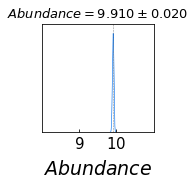

In [ ]:
parameter_names = ['Source1']
parameter_labels = ['Abundance']
samples = posterior.sample((10000,), x=observation) #100000
ranges = dict(zip(parameter_names, np.array(parameter_range).T.reshape((np.array(parameter_range[0]).size,2))))
mcsamples = MCSamples(samples=samples.numpy(), names = parameter_names, labels = parameter_labels, ranges = ranges)

g = plots.get_subplot_plotter()
g.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
g.settings.axes_fontsize=18
g.settings.legend_fontsize = 26
g.settings.axes_labelsize = 22
g.settings.norm_1d_density = True
g.settings.title_limit = 1
g.triangle_plot(mcsamples, filled=True, markers=input_params.numpy(), param_limits=ranges)